In [1]:
import numpy as np
from numpy import genfromtxt
from scipy import stats
from scipy import signal
from scipy import integrate
import matplotlib.pyplot as plt

# Inciso 1: Esquema BPSK

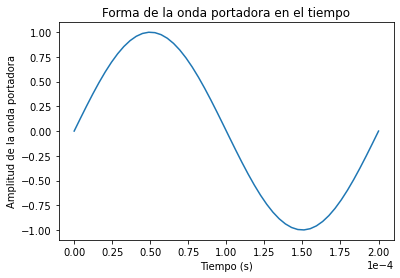

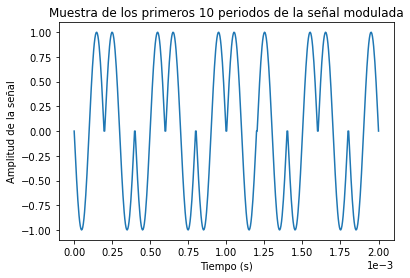

<Figure size 432x288 with 0 Axes>

In [7]:
'''
1. Crear un esquema de modulación BPSK para los bits presentados. 
Esto implica asignar una forma de onda sinusoidal normalizada (amplitud unitaria) para cada bit y 
luego una concatenación de todas estas formas de onda. Se asigna una onda positiva a un bit de 1 y una
negativa a un bit de 0

Observaciones (para asumir en esta simulación):

- f = 5000 Hz (frecuencia de la portadora)
- Un período de transmisión del símbolo es un período completo de la portadora
'''

# bits para "transmitir", leídos desde el CSV del enunciado
bits = genfromtxt("bits10k.csv", delimiter = ',')

# Número de bits
N = len(bits)

# Frecuencia de operación
f = 5000 # Hz

# Duración del período de cada símbolo (onda)
T = 1/f # 1 ms

# Número de puntos de muestreo por período
p = 50

# Puntos de muestreo para cada período
tp = np.linspace(0, T, p)

# Creación de la forma de onda de la portadora
sinus = np.sin(2*np.pi * f * tp)

# Visualización de la forma de onda de la portadora
plt.plot(tp, sinus)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud de la onda portadora')
plt.title('Forma de la onda portadora en el tiempo')
plt.ticklabel_format(axis = "x", style = "sci", scilimits=(0,0))
plt.savefig('img/portadora.png')
plt.show()

# Frecuencia de muestreo
fs = p/T # 50 kHz

# Creación de la línea temporal para toda la señal Tx
t = np.linspace(0, N*T, N*p)

# Inicializar el vector de la señal
senal = np.zeros(t.shape)

# Creación de la señal modulada BPSK
for k, b in enumerate(bits):
        senal[k*p:(k+1)*p] = sinus if b else -sinus

# Visualización de los primeros bits modulados
pb = 10
tp = np.linspace(0, pb*T, pb*p)
plt.figure()
plt.plot(tp, senal[0:pb*p])
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud de la señal")
plt.title("Muestra de los primeros " + str(pb) + " periodos de la señal modulada")
plt.ticklabel_format(axis = "x", style = "sci", scilimits=(0,0))
plt.show()
plt.savefig('img/Tx.png')


# Inciso 2: Potencia promedio de la señal modulada

Se utiliza la fórmula de potencia promedio:

$$
P(T) = \frac{1}{2T}\int_{-T}^{T}x^2(t)  
$$

In [3]:
'''
2. Calcular la potencia promedio
'''

# Potencia instantánea
Pinst = senal**2

# Potencia promedio (W)
Ps = integrate.trapz(Pinst, t) / (N * T)

print("La potencia promedio de la señal modulada generada tiene un valor numérico de:", Ps)

La potencia promedio de la señal modulada generada es de: 0.4900009800019598


# Incisos 3, 4 y 5: Simulación del canal ruidoso AWGN, graficación de la densidad espectral de potencia con Welch y demodulación de la señal recibida

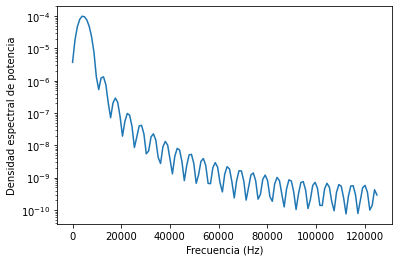

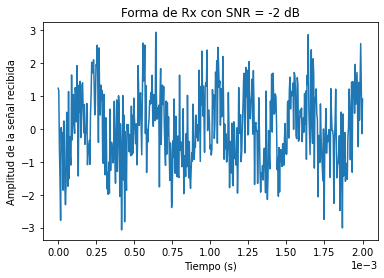

<Figure size 432x288 with 0 Axes>

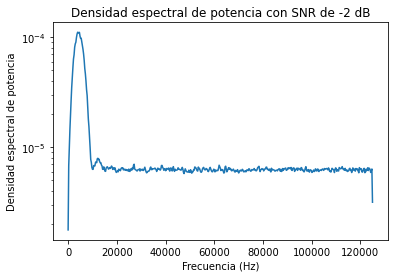

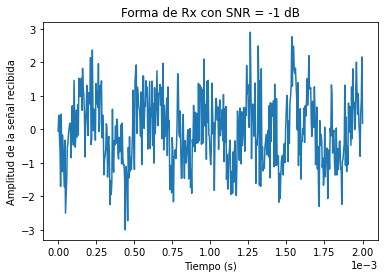

<Figure size 432x288 with 0 Axes>

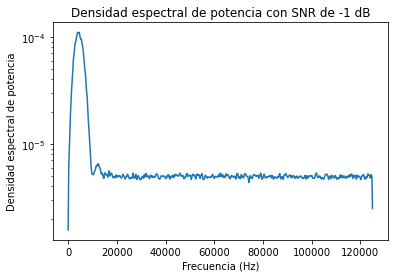

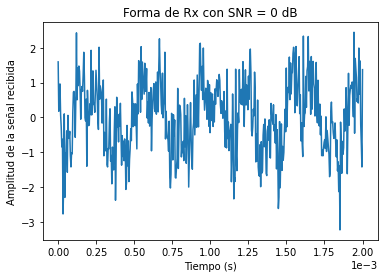

<Figure size 432x288 with 0 Axes>

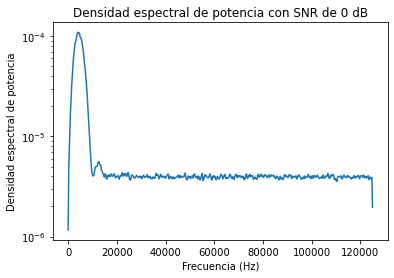

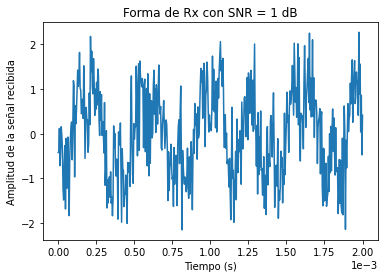

<Figure size 432x288 with 0 Axes>

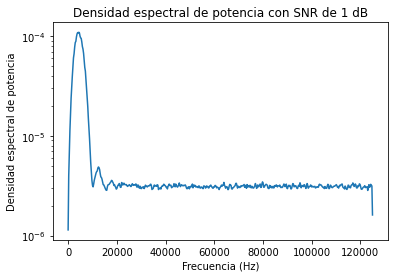

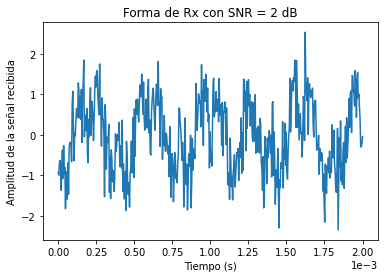

<Figure size 432x288 with 0 Axes>

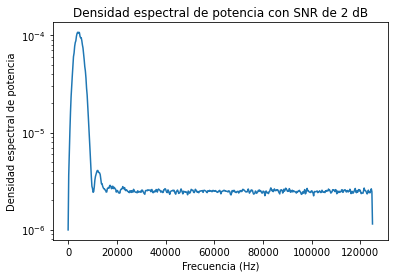

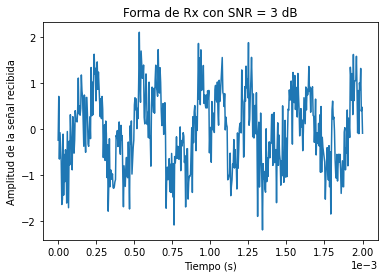

<Figure size 432x288 with 0 Axes>

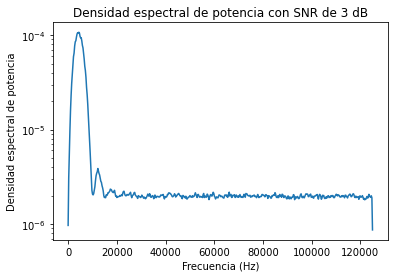

In [4]:
'''
3. Simular un canal ruidoso del tipo AWGN (ruido aditivo blanco gaussiano)
4. Graficar la densidad espectral de potencia de la señal con Welch (SciPy), antes y después del canal ruidoso
Realizado con cada nivel de SNR
5. Demodular y decodificar la señal y hacer un conteo del BER para cada nivel de SNR
'''

# Potencia con Welch antes del canal ruidoso
fw, PSD = signal.welch(senal, fs)
plt.figure()
plt.semilogy(fw, PSD)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral de potencia')
plt.savefig("img/powerNoNoise.png")
plt.show()

# Listas para la graficación de BER vs SNR
BER = [] # Lista para obtener los valores de BER con cada dB de SNR
snrVals = list(range(-2,4)) # Rango de valores de SNR deseados, con 1 dB entre cada uno

# Relación señal-a-ruido deseada
for SNR in snrVals:
    # Variable para nombrar las figuras de la señal recibida con cada SNR
    nameRxPlot = "Rx_SNR" + str(SNR) + ".png"
    
    # Variable para nombrar la densidad espectral (con el método de Welch) para cada SNR
    
    # Potencia del ruido para SNR y potencia de la señal dadas
    Pn = Ps / (10**(SNR / 10))

    # Desviación estándar del ruido
    sigma = np.sqrt(Pn)

    # Crear ruido (Pn = sigma^2)
    ruido = np.random.normal(0, sigma, senal.shape)

    # Simular "el canal": señal recibida
    Rx = senal + ruido

    # Visualización de los primeros bits recibidos
    plt.figure()
    plt.plot(tp, Rx[0:pb*p])
    plt.ticklabel_format(axis = "x", style = "sci", scilimits=(0,0))
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud de la señal recibida")
    plt.title("Forma de Rx con SNR = " + str(SNR) + " dB")
    plt.show()
    plt.savefig("img/" + nameRxPlot)

    # Pseudo-energía de la onda original
    Es = np.sum(sinus**2)

    # Inicialización del vector de bits recibidos
    bitsRx = np.zeros(bits.shape)

    # Decodificación de la señal por detección de energía
    for k, b in enumerate(bits):
        # Producto interno de dos funciones
        Ep = np.sum(Rx[k*p:(k+1)*p] * sinus)
        
        # Se escoge un umbral de 0 dado que el producto interno de 
        # -sin(x) y sin(x) (que es la suma de todos los valores de x en -sin(x)^2) es 0 sin ruido
        # El ruido es aditivo en todo el dominio, por lo que es esperable que haya una cantidad 
        # similar de ruido en las partes negativas y las positivas de la señal transmitida, por lo que
        # es esperable que la suma del producto interno es similar a 0 
        bitsRx[k] = 1 if (Ep > 0) else 0
    
    # Potencia con Welch después del canal ruidoso
    fw, PSD = signal.welch(Rx, fs, nperseg=1024)
    plt.figure()
    plt.semilogy(fw, PSD)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Densidad espectral de potencia')
    plt.title("Densidad espectral de potencia con SNR de " + str(SNR) + " dB")
    plt.savefig("img/powerSNR" + str(SNR) + ".png")
    plt.show()

    # err es la cantidad de bits erróneros en la señal recibida con respecto a la transmitida
    err = np.sum(np.abs(bits - bitsRx))
    BER.append(err/N)


# Inciso 6: Graficación de BER vs SNR

<function matplotlib.pyplot.show(*args, **kw)>

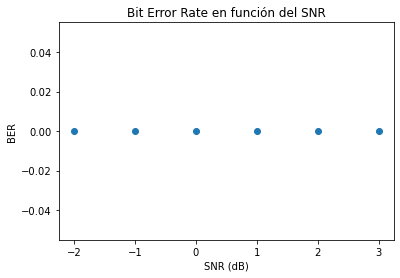

In [5]:
# Graficación de BER vs SNR
plt.figure()
plt.scatter(snrVals, BER)
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.title("Bit Error Rate en función del SNR")
plt.savefig("img/BERvsSNR")
plt.show